In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate,GlobalAveragePooling2D,Multiply, LSTM, Bidirectional, TimeDistributed,
    Add, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score, precision_recall_curve, auc

import seaborn as sns
import os
import random
import csv
import cv2


In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("[INFO] Enabled Memory Growth for GPU")
    except RuntimeError as e:
        print(e)


[INFO] Enabled Memory Growth for GPU


In [17]:
import os
import csv
import random

def collect_image_sequences(base_folder, sequence_length=10):
    """
    Recursively collect sequences of image paths from subdirectories.
    Returns a list of lists where each inner list contains a sequence of frame paths.
    """
    sequences = []
    for root, _, files in os.walk(base_folder):
        image_files = sorted([f for f in files if f.endswith(('.png', '.jpg', '.jpeg'))])

        # Ensure we have enough frames for a sequence
        if len(image_files) >= sequence_length:
            for i in range(len(image_files) - sequence_length + 1):  # Sliding window
                sequence = [os.path.join(root, image_files[j]) for j in range(i, i + sequence_length)]
                sequences.append(sequence)
    
    return sequences

def prepare_dataset(real_faces_folder, real_flow_folder, fake_faces_folder, fake_flow_folder, output_csv, sequence_length=10):
    """
    Prepare a CSV dataset mapping spatial frames (cropped faces) and sequences of optical flow images 
    for real and fake data.
    """
    dataset = []

    def process_real_data(cropped_faces_folder, optical_flow_folder, label):
        """
        Process real data, pairing spatial frames with a directory containing optical flow sequences.
        """
        print("[INFO] Processing real data...")
        for subdir_name in sorted(os.listdir(cropped_faces_folder)):
            subdir_path = os.path.join(cropped_faces_folder, subdir_name)
            flow_path = os.path.join(optical_flow_folder, subdir_name)

            if not os.path.isdir(subdir_path) or not os.path.isdir(flow_path):
                continue

            spatial_frames = sorted([os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
            optical_flow_sequences = collect_image_sequences(flow_path, sequence_length)

            for frame, flow_sequence in zip(spatial_frames, optical_flow_sequences):
                dataset.append([frame, flow_path, label])  # Store directory path instead of single file

    def process_fake_data(cropped_faces_folder, optical_flow_folder, label):
        """
        Process fake data, ensuring sequences of optical flow frames are paired correctly.
        """
        print("[INFO] Processing fake data...")
        for root, dirs, files in os.walk(cropped_faces_folder):
            if "end_to_end" not in root:
                continue

            # Extract relative path for matching optical flow directory
            relative_path = os.path.relpath(root, cropped_faces_folder)
            flow_path = os.path.join(optical_flow_folder, relative_path)
            
            if not os.path.isdir(flow_path):
                print(f"[DEBUG] Skipping: Optical flow folder does not exist for {root}.")
                continue

            spatial_frames = sorted([os.path.join(root, f) for f in files if f.endswith(('.png', '.jpg', '.jpeg'))])
            optical_flow_sequences = collect_image_sequences(flow_path, sequence_length)

            for frame, flow_sequence in zip(spatial_frames, optical_flow_sequences):
                dataset.append([frame, flow_path, label])  # Store flow directory

    # Process real data
    process_real_data(real_faces_folder, real_flow_folder, label=0)

    # Process fake data
    process_fake_data(fake_faces_folder, fake_flow_folder, label=1)

    # Shuffle and save to CSV
    print(f"[INFO] Total dataset size before shuffling: {len(dataset)}")
    random.shuffle(dataset)
    with open(output_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["spatial_frame", "optical_flow_directory", "label"])  # Update column names
        writer.writerows(dataset)
    
    print(f"[INFO] CSV saved to: {output_csv}")

# Define paths
real_faces = "E:/Research/real/Cropped_Faces"
real_flow = "E:/Research/real/Optical_Flow"
fake_faces = "E:/Research/fake/Cropped_Faces"
fake_flow = "E:/Research/fake/Optical_Flow"
output_csv = "angry_dataset_real_fake_filtered.csv"

# Prepare the dataset
prepare_dataset(real_faces, real_flow, fake_faces, fake_flow, output_csv, sequence_length=10)
print("[INFO] Dataset preparation complete.")


[INFO] Processing real data...
[INFO] Processing fake data...
[INFO] Total dataset size before shuffling: 1375198
[INFO] CSV saved to: angry_dataset_real_fake_filtered.csv
[INFO] Dataset preparation complete.


In [18]:
import os
import csv
import random

def collect_image_sequences(base_folder, sequence_length=10):
    """
    Recursively collect sequences of image paths from subdirectories.
    Returns a list of lists where each inner list contains a sequence of frame paths.
    """
    sequences = []
    for root, _, files in os.walk(base_folder):
        image_files = sorted([f for f in files if f.endswith(('.png', '.jpg', '.jpeg'))])

        # Ensure we have enough frames for a sequence
        if len(image_files) >= sequence_length:
            for i in range(len(image_files) - sequence_length + 1):  # Sliding window
                sequence = [os.path.join(root, image_files[j]) for j in range(i, i + sequence_length)]
                sequences.append(sequence)
    
    return sequences

def prepare_dataset(real_faces_folder, real_flow_folder, fake_faces_folder, fake_flow_folder, output_csv_prefix, sequence_length=10):
    """
    Prepare a CSV dataset mapping spatial frames (cropped faces) and sequences of optical flow images 
    for real and fake data, ensuring a 1:1 real:fake ratio across 4 output CSV files.
    """
    real_dataset = []
    fake_dataset = []

    def process_real_data(cropped_faces_folder, optical_flow_folder, label):
        """
        Process real data, pairing spatial frames with a directory containing optical flow sequences.
        """
        print("[INFO] Processing real data...")
        for subdir_name in sorted(os.listdir(cropped_faces_folder)):
            subdir_path = os.path.join(cropped_faces_folder, subdir_name)
            flow_path = os.path.join(optical_flow_folder, subdir_name)

            if not os.path.isdir(subdir_path) or not os.path.isdir(flow_path):
                continue

            spatial_frames = sorted([os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
            optical_flow_sequences = collect_image_sequences(flow_path, sequence_length)

            for frame, flow_sequence in zip(spatial_frames, optical_flow_sequences):
                real_dataset.append([frame, flow_path, label])  # Store directory path instead of single file

    def process_fake_data(cropped_faces_folder, optical_flow_folder, label):
        """
        Process fake data, ensuring sequences of optical flow frames are paired correctly.
        """
        print("[INFO] Processing fake data...")
        for root, dirs, files in os.walk(cropped_faces_folder):
            if "end_to_end" not in root:
                continue

            # Extract relative path for matching optical flow directory
            relative_path = os.path.relpath(root, cropped_faces_folder)
            flow_path = os.path.join(optical_flow_folder, relative_path)
            
            if not os.path.isdir(flow_path):
                print(f"[DEBUG] Skipping: Optical flow folder does not exist for {root}.")
                continue

            spatial_frames = sorted([os.path.join(root, f) for f in files if f.endswith(('.png', '.jpg', '.jpeg'))])
            optical_flow_sequences = collect_image_sequences(flow_path, sequence_length)

            for frame, flow_sequence in zip(spatial_frames, optical_flow_sequences):
                fake_dataset.append([frame, flow_path, label])  # Store flow directory

    # Process real and fake data separately
    process_real_data(real_faces_folder, real_flow_folder, label=0)
    process_fake_data(fake_faces_folder, fake_flow_folder, label=1)

    # Ensure real:fake ratio is balanced
    real_count = len(real_dataset)
    fake_count = len(fake_dataset)
    min_count = min(real_count, fake_count)  # Balance both classes

    print(f"[INFO] Total Real Samples: {real_count}")
    print(f"[INFO] Total Fake Samples: {fake_count}")
    print(f"[INFO] Balancing dataset to {min_count} samples per class...")

    real_dataset = real_dataset[:min_count]
    fake_dataset = fake_dataset[:min_count]

    # Merge, shuffle, and split dataset
    dataset = real_dataset + fake_dataset
    random.shuffle(dataset)

    total_size = len(dataset)
    part_size = total_size // 4  # Split into 4 equal parts

    print(f"[INFO] Total dataset size after balancing: {total_size}")
    print(f"[INFO] Each split will have approximately {part_size} samples.")

    # Save dataset in 4 parts
    for i in range(4):
        part_data = dataset[i * part_size : (i + 1) * part_size]
        output_csv = f"{output_csv_prefix}_part{i+1}.csv"

        with open(output_csv, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(["spatial_frame", "optical_flow_directory", "label"])  # Update column names
            writer.writerows(part_data)

        print(f"[INFO] CSV saved to: {output_csv}")

# Define paths
real_faces = "E:/Research/real/Cropped_Faces"
real_flow = "E:/Research/real/Optical_Flow"
fake_faces = "E:/Research/fake/Cropped_Faces"
fake_flow = "E:/Research/fake/Optical_Flow"
output_csv_prefix = "angry_dataset_real_fake"

# Prepare the dataset and split into 4 balanced parts
prepare_dataset(real_faces, real_flow, fake_faces, fake_flow, output_csv_prefix, sequence_length=10)

print("[INFO] Dataset preparation complete.")


[INFO] Processing real data...
[INFO] Processing fake data...
[INFO] Total Real Samples: 832406
[INFO] Total Fake Samples: 542792
[INFO] Balancing dataset to 542792 samples per class...
[INFO] Total dataset size after balancing: 1085584
[INFO] Each split will have approximately 271396 samples.
[INFO] CSV saved to: angry_dataset_real_fake_part1.csv
[INFO] CSV saved to: angry_dataset_real_fake_part2.csv
[INFO] CSV saved to: angry_dataset_real_fake_part3.csv
[INFO] CSV saved to: angry_dataset_real_fake_part4.csv
[INFO] Dataset preparation complete.


In [19]:
# Define Focal Loss
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(loss)
    return focal_loss_fixed

# Define CNN for spatial feature extraction
def create_cnn(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    x = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.2)(x)

    # Attention mechanism
    attention = GlobalAveragePooling2D()(x)  # (batch_size, 64)
    attention = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(attention)
    attention = Dense(32, activation="sigmoid", kernel_regularizer=l2(0.001))(attention)

    # Reshape attention to match feature maps
    attention = tf.expand_dims(tf.expand_dims(attention, axis=1), axis=1)  # (batch_size, 1, 1, 64)

    x = Multiply()([x, attention])  # Corrected attention multiplication
    
    x = GlobalAveragePooling2D()(x)
    
    return inputs, x


# Define LSTM for temporal feature extraction
def create_bilstm(input_shape, sequence_length=10):
    inputs = Input(shape=(sequence_length, input_shape[0], input_shape[1], input_shape[2]))

    x = TimeDistributed(Conv2D(16, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001)))(inputs)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Dropout(0.2))(x)

    x = TimeDistributed(Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(0.001)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Dropout(0.2))(x)

    x = TimeDistributed(GlobalAveragePooling2D())(x)  
    x = TimeDistributed(Dense(128, activation="relu"))(x)  # Expand feature vector for LSTM

    print(f"Shape before Reshape: {x.shape}")

    x = Reshape((sequence_length, x.shape[-1]))(x)  
    x = Bidirectional(LSTM(16, return_sequences=False, kernel_regularizer=l2(0.001)))(x)

    return inputs, x



# Define input shapes
image_shape = (256, 256, 3)  # RGB input for spatial features
video_frame_shape = (256, 256, 3)  
sequence_length = 10 

# Extract spatial features
spatial_input, spatial_features = create_cnn(image_shape)

# Extract temporal features using Bi-LSTM CNN
temporal_input, temporal_features = create_bilstm(video_frame_shape, sequence_length)
# Align spatial and temporal features
spatial_features = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(spatial_features)
temporal_features = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(temporal_features)

# Combine features
combined = tf.keras.layers.concatenate([spatial_features, temporal_features])

# Fully connected layers with Dropout
x = Dense(64, activation="relu", kernel_regularizer=l2(0.001))(combined)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(1, activation="sigmoid")(x)  # Binary classification

# Model
model = Model(inputs=[spatial_input, temporal_input], outputs=x)

# Compile model with Adam optimizer and Focal Loss
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss=focal_loss(alpha=0.25, gamma=2.0), 
              metrics=["accuracy"])

model.summary()

Shape before Reshape: (None, 10, 128)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 256, 256, 16  64         ['conv2d_4[0][0]']               
 rmalization)                   )                     

In [20]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size, sequence_length=10, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.data = data  # List of tuples: (spatial_frame_path, optical_flow_directory, label)
        self.batch_size = batch_size
        self.sequence_length = sequence_length  # Number of frames in the optical flow sequence
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return len(self.data) // self.batch_size

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch = [self.data[i] for i in batch_indexes]

        spatial_frames = []
        optical_flow_sequences = []
        labels = []

        for row in batch:
            spatial_frame_path = row[0]  # Single spatial frame
            optical_flow_dir = row[1]  # Directory containing optical flow sequence
            label = row[2]

            # Load Spatial Frame (Single Image)
            spatial_frame = cv2.imread(spatial_frame_path)
            if spatial_frame is None:
                print(f"[WARNING] Missing spatial frame: {spatial_frame_path}")
                spatial_frame = np.zeros((256, 256, 3))  # Use black frame if missing
            else:
                spatial_frame = cv2.resize(spatial_frame, (256, 256)) / 255.0  # Normalize

            # Load Optical Flow Sequence (Multiple Frames)
            optical_flow_sequence = self.load_optical_flow_sequence(optical_flow_dir)

            spatial_frames.append(spatial_frame)
            optical_flow_sequences.append(optical_flow_sequence)
            labels.append(label)

        # Convert to NumPy Arrays
        spatial_frames = np.array(spatial_frames, dtype="float32")  # Shape: (batch_size, 256, 256, 3)
        optical_flow_sequences = np.array(optical_flow_sequences, dtype="float32")  # Shape: (batch_size, time_steps, 256, 256, 3)
        labels = np.array(labels, dtype="float32").reshape(-1, 1)  # Shape: (batch_size, 1)

        # Convert to TensorFlow Tensors
        spatial_frames = tf.convert_to_tensor(spatial_frames)
        optical_flow_sequences = tf.convert_to_tensor(optical_flow_sequences)
        labels = tf.convert_to_tensor(labels)
        # print(f"[DEBUG] Spatial Frames Shape: {np.array(spatial_frames).shape}")
        # print(f"[DEBUG] Optical Flow Sequence Shape: {np.array(optical_flow_sequences).shape}")

        return (spatial_frames, optical_flow_sequences), labels

    def load_optical_flow_sequence(self, flow_dir):
        """
        Loads a sequence of optical flow frames from the given directory.
        Ensures the sequence has exactly `self.sequence_length` frames.
        """
        frame_paths = sorted([os.path.join(flow_dir, f) for f in os.listdir(flow_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

        # Ensure we have enough frames
        if len(frame_paths) < self.sequence_length:
            print(f"[WARNING] Not enough frames in {flow_dir}. Found {len(frame_paths)}, needed {self.sequence_length}.")
            frame_paths += [None] * (self.sequence_length - len(frame_paths))  # Fill missing frames with None

        # Load frames
        optical_flow_sequence = []
        for frame_path in frame_paths[:self.sequence_length]:  # Only take `sequence_length` frames
            if frame_path is None or not os.path.exists(frame_path):
                optical_flow_sequence.append(np.zeros((256, 256, 3)))  # Use black frame if missing
            else:
                frame = cv2.imread(frame_path)
                frame = cv2.resize(frame, (256, 256)) / 255.0  # Normalize
                optical_flow_sequence.append(frame)

        return np.array(optical_flow_sequence, dtype="float32")  # Shape: (sequence_length, 256, 256, 3)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def reset(self):
        """Reset the generator to start from the beginning."""
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [21]:


# Load dataset from CSV
df = pd.read_csv("angry_dataset_real_fake_part1.csv")

# Convert DataFrame into a list of tuples: [(spatial_frame, optical_flow_directory, label)]
dataset = list(df.itertuples(index=False, name=None))  # Convert rows to tuples

# Split into training and validation sets (ensuring data format consistency)
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Create DataGenerator instances
train_gen = DataGenerator(train_data, batch_size=2, sequence_length=10, shuffle=True)
val_gen = DataGenerator(val_data, batch_size=2, sequence_length=10, shuffle=False)

# Example batch test
inputs, labels_batch = train_gen[0]
spatial_batch, temporal_batch = inputs  # Unpack spatial & temporal features

# No need to reshape labels (already handled in DataGenerator)
print(f"Spatial batch shape: {spatial_batch.shape}")  # Expected: (batch_size, 256, 256, 3)
print(f"Temporal batch shape: {temporal_batch.shape}")  # Expected: (batch_size, sequence_length, 256, 256, 3)
print(f"Labels batch shape: {labels_batch.shape}")  # Expected: (batch_size, 1)


Spatial batch shape: (2, 256, 256, 3)
Temporal batch shape: (2, 10, 256, 256, 3)
Labels batch shape: (2, 1)


In [24]:
# Load the dataset from the CSV file
df = pd.read_csv("angry_dataset_real_fake_part1.csv")

# Convert DataFrame into a list of tuples: [(spatial_frame, optical_flow_directory, label)]
dataset = list(df.itertuples(index=False, name=None))

# Split into training and validation sets
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Initialize data generators (Ensure sequence_length is passed)
train_gen = DataGenerator(train_data, batch_size=16, sequence_length=10, shuffle=True)
val_gen = DataGenerator(val_data, batch_size=16, sequence_length=10, shuffle=False)

# Define Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",  
    patience=5,  # Increased patience to prevent premature stopping
    restore_best_weights=True,  
    verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",  
    factor=0.1,  
    patience=2,  
    min_lr=1e-6,  
    verbose=1
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="angry_expression_model_best.h5",  
    monitor="val_loss",  
    save_best_only=True,  
    save_weights_only=False,  
    mode="min",  
    verbose=1  
)

# **Ensure Model is Compiled Before Training**
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=focal_loss(alpha=0.25, gamma=2.0),  # Use focal loss for class imbalance
    metrics=["accuracy"]
)

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 256, 256, 16  448         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 256, 256, 16  64         ['conv2d_4[0][0]']               
 rmalization)                   )                                                           

In [25]:

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1,  # Set to 1 for detailed logs
    callbacks=[
        # early_stopping, lr_scheduler, 
        model_checkpoint]  # Include callbacks
)

print("[INFO] Model training completed. Best model saved as 'angry_expression_model_best.h5'.")

Epoch 1/10
13569/13569 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.5010
Epoch 1: val_loss improved from inf to 0.00000, saving model to angry_expression_model_best.h5
13569/13569 [==============================] - 6867s 506ms/step - loss: 0.0144 - accuracy: 0.5010 - val_loss: 8.4220e-09 - val_accuracy: 0.4985
Epoch 2/10
13569/13569 [==============================] - ETA: 0s - loss: 3.6319e-07 - accuracy: 0.5010
Epoch 2: val_loss improved from 0.00000 to 0.00000, saving model to angry_expression_model_best.h5
13569/13569 [==============================] - 6343s 467ms/step - loss: 3.6319e-07 - accuracy: 0.5010 - val_loss: 5.9994e-11 - val_accuracy: 0.4985
Epoch 3/10
13569/13569 [==============================] - ETA: 0s - loss: 4.4883e-08 - accuracy: 0.5010
Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to angry_expression_model_best.h5
13569/13569 [==============================] - 6345s 468ms/step - loss: 4.4883e-08 - accuracy: 0.5010 - val

KeyboardInterrupt: 

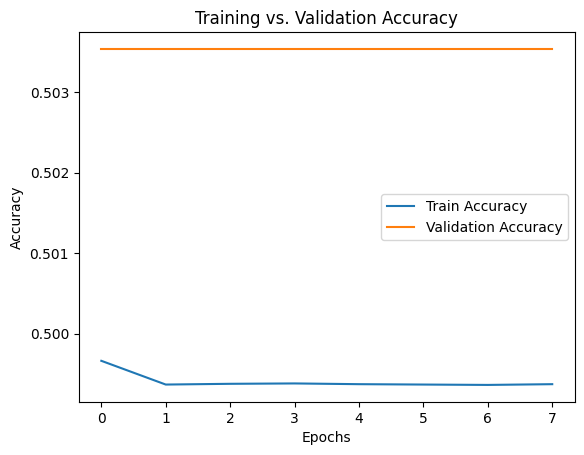

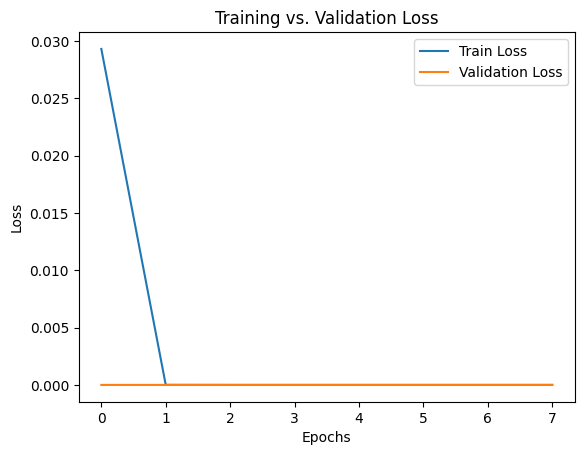

In [26]:

# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs. Validation Accuracy")
plt.show()

# Plot training and validation loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()

In [6]:
model_path = r"D:\school\Research\TC-FET-Deepfake-Detector\angry\lstm_exp1\angry_expression_model_best.h5"
# Load the saved model
model = load_model(model_path)

# Verify the model structure (optional)
model.summary()

ValueError: Unknown loss function: focal_loss_fixed. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

Model Input Shape: [(None, 256, 256, 3), (None, 10, 256, 256, 3)]
Spatial Frames Shape: (16, 256, 256, 3)
Optical Flows Shape: (16, 10, 256, 256, 3)
Labels Shape: (16, 1)
3392/3392 [==============================] - 986s 290ms/step
Accuracy Score: 0.4985
ROC AUC Score: 0.5000
Recall Score: 1.0000
Precision Score: 0.4985
PR AUC Score: 0.7493


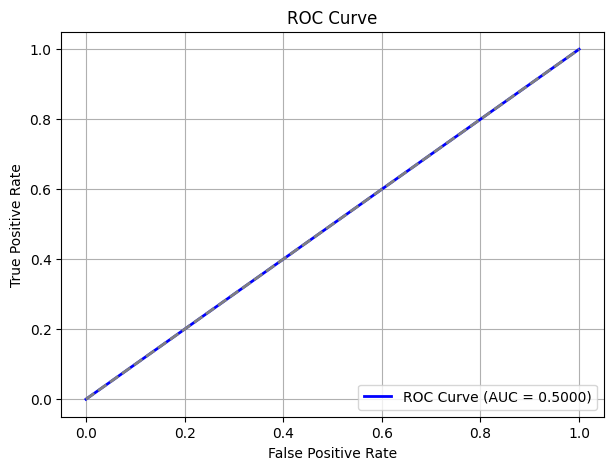

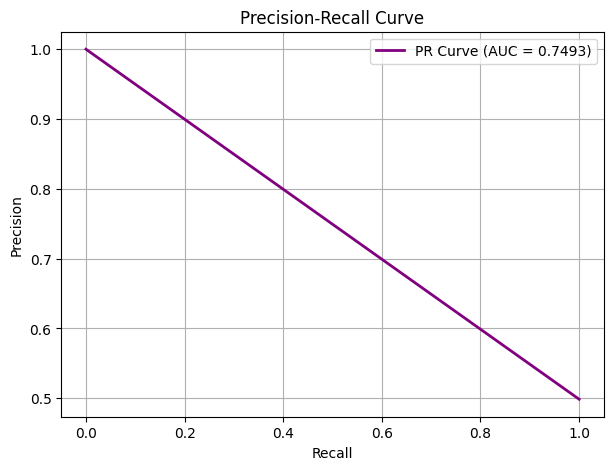

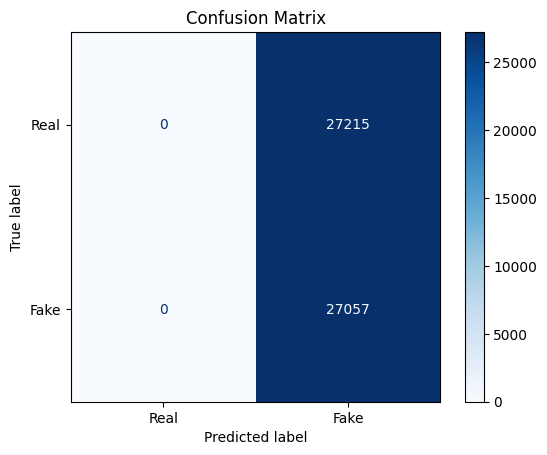

In [27]:
# Ensure DataGenerator uses correct sequence length for Bi-LSTM
val_gen = DataGenerator(val_data, batch_size=16, sequence_length=10)

# Step 1: Verify DataGenerator Output
(spatial_frames, optical_flows), labels = val_gen[0]
print("Model Input Shape:", model.input_shape)
print("Spatial Frames Shape:", spatial_frames.shape)  # Expected: (batch_size, 256, 256, 3)
print("Optical Flows Shape:", optical_flows.shape)  # Expected: (batch_size, sequence_length, 256, 256, 3)
print("Labels Shape:", labels.shape)  # Expected: (batch_size, 1)

# Step 2: Generate Predictions
val_probabilities = model.predict(val_gen).squeeze()  # Ensure 1D shape
val_predictions = (val_probabilities > 0.5).astype(int)  # Convert to binary predictions

# Step 3: Extract Ground Truth Labels Efficiently
val_labels = np.concatenate([batch_labels.numpy().flatten() for _, batch_labels in val_gen])[:len(val_predictions)]

# Step 4: Evaluate Metrics
accuracy = accuracy_score(val_labels, val_predictions)
roc_auc = roc_auc_score(val_labels, val_probabilities)
recall = recall_score(val_labels, val_predictions)
precision = precision_score(val_labels, val_predictions)
precision_vals, recall_vals, _ = precision_recall_curve(val_labels, val_probabilities)
pr_auc = auc(recall_vals, precision_vals)

# Print Metrics
print(f"Accuracy Score: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Recall Score: {recall:.4f}")
print(f"Precision Score: {precision:.4f}")
print(f"PR AUC Score: {pr_auc:.4f}")

# Step 5: Visualize Metrics

# ROC Curve
fpr, tpr, _ = roc_curve(val_labels, val_probabilities)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Precision-Recall Curve
plt.figure(figsize=(7, 5))
plt.plot(recall_vals, precision_vals, color='purple', lw=2, label=f"PR Curve (AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="upper right")
plt.grid()
plt.show()

# Confusion Matrix
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
